In [1]:
import math
import operator
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from beautifultable import BeautifulTable
from xgboost import XGBClassifier
from sklearn import svm
from sklearn.model_selection import LeaveOneOut, GridSearchCV,StratifiedKFold ,KFold
# from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.metrics import roc_auc_score, auc, accuracy_score
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')  


In [2]:
def printConfusionMatrix(trueNegative, falsePositive, falseNegative, truePositive):
    tableData = []
    row1 = []
    row1.append('')
    row1.append('Predicted Pos')
    row1.append('Predicted Neg')
    tableData.append(row1)
    
    row2 = []
    row2.append('Actual Pos')
    row2.append(truePositive)
    row2.append(falseNegative)
    tableData.append(row2)
    
    row3 = []
    row3.append('Actual Neg')
    row3.append(falsePositive)
    row3.append(trueNegative)
    tableData.append(row3)
    
    printDatainTable([], tableData)

In [3]:
def printDatainTable(tableHeaders, tableData):
    table = BeautifulTable(max_width=100)
    table.set_style(BeautifulTable.STYLE_SEPARATED)
    if len(tableHeaders)!=0:
        table.column_headers = tableHeaders
    for i in range(0, len(tableData)):
        table.append_row(tableData[i])
    print(table)

In [4]:
aps_failure_training_file = '../data/aps_failure_training_set.csv'
aps_failure_testing_file = '../data/aps_failure_test_set.csv'
aps_failure_description_file = '../data/aps_failure_description.txt'
apsTrainData = pd.read_csv(aps_failure_training_file, skiprows=20, na_values='na')
apsTestData = pd.read_csv(aps_failure_testing_file, skiprows=20, na_values='na')


# 1. a) Read APS failure data

In [5]:
print(apsTrainData.head())

  class  aa_000  ab_000        ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg   76698     NaN  2.130706e+09   280.0     0.0     0.0     0.0     0.0   
1   neg   33058     NaN  0.000000e+00     NaN     0.0     0.0     0.0     0.0   
2   neg   41040     NaN  2.280000e+02   100.0     0.0     0.0     0.0     0.0   
3   neg      12     0.0  7.000000e+01    66.0     0.0    10.0     0.0     0.0   
4   neg   60874     NaN  1.368000e+03   458.0     0.0     0.0     0.0     0.0   

   ag_002  ...     ee_002    ee_003    ee_004    ee_005    ee_006    ee_007  \
0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0  157956.0   
1     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   81140.0   
2     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0  158022.0   
3     0.0  ...      240.0      46.0      58.0      44.0      10.0       0.0   
4     0.0  ...   622012.0  229790.0  405298.0  347188.0  286954.0  311560.0   

     ee_008  ee_009  ef_000  eg_000  


In [6]:
print(apsTestData.head())

  class  aa_000  ab_000  ac_000  ad_000  ae_000  af_000  ag_000  ag_001  \
0   neg      60     0.0    20.0    12.0     0.0     0.0     0.0     0.0   
1   neg      82     0.0    68.0    40.0     0.0     0.0     0.0     0.0   
2   neg   66002     2.0   212.0   112.0     0.0     0.0     0.0     0.0   
3   neg   59816     NaN  1010.0   936.0     0.0     0.0     0.0     0.0   
4   neg    1814     NaN   156.0   140.0     0.0     0.0     0.0     0.0   

   ag_002  ...    ee_002    ee_003    ee_004    ee_005     ee_006    ee_007  \
0     0.0  ...    1098.0     138.0     412.0     654.0       78.0      88.0   
1     0.0  ...    1068.0     276.0    1620.0     116.0       86.0     462.0   
2     0.0  ...  495076.0  380368.0  440134.0  269556.0  1315022.0  153680.0   
3     0.0  ...  540820.0  243270.0  483302.0  485332.0   431376.0  210074.0   
4     0.0  ...    7646.0    4144.0   18466.0   49782.0     3176.0     482.0   

     ee_008  ee_009  ef_000  eg_000  
0       0.0     0.0     0.0     0.0 

In [7]:
apsData = pd.concat([apsTrainData, apsTestData])
apsDataY = pd.DataFrame(apsData['class'])
apsDataX = pd.DataFrame(apsData.drop(columns=['class']))
apsFeatures = apsDataX.columns

apsTrainDataY = pd.DataFrame(apsTrainData['class'])
apsTrainDataX = pd.DataFrame(apsTrainData[apsFeatures])

apsTestDataY = pd.DataFrame(apsTestData['class'])
apsTestDataX = pd.DataFrame(apsTestData[apsFeatures])

# 1. b) Techniques to handle missing values.
Substitute missing values with a constant (distinct from all other values) that has a meaning in that domain.
Substitute missing values with the value of the randomly selected observation.
Use statistics such as Mean, Median, Mode to fill out missing values.
Use predictive models where missing values are treated as output of the predictive model and are predicted based on other data points that do not have missing values.
Use iterative methods based on Expectation Maximization to handle missing values.
I will use mean of the feature to fill out any missing values for that feature in the observations.

# Handling missing values

In [8]:
# Replace na with NaN
apsDataX = apsDataX.replace({'na':None}) 
apsDataX = apsDataX.astype('float64')
apsTrainDataX = apsTrainDataX.replace({'na':None}) 
apsTrainDataX = apsTrainDataX.astype('float64')
apsTestDataX = apsTestDataX.replace({'na':None}) 
apsTestDataX = apsTestDataX.astype('float64')

# Find mean for each feature
apsMeansList = apsDataX.mean()
for i in range(0, len(apsMeansList)):
    apsMeansList[i] = round(apsMeansList[i], 2)

# Fill NaN with mean of that column
apsDataX = apsDataX.fillna(apsMeansList)
apsTrainDataX = apsTrainDataX.fillna(apsMeansList)
apsTestDataX = apsTestDataX.fillna(apsMeansList)

actualDataY = np.array(apsDataY).flatten()
actualTrainDataY = np.array(apsTrainDataY).flatten()
actualTestDataY = np.array(apsTestDataY).flatten()

for i in range(0, len(actualDataY)):
    if actualDataY[i]=='neg':
        actualDataY[i] = 0
    else:
        actualDataY[i] = 1

for i in range(0, len(actualTrainDataY)):
    if actualTrainDataY[i]=='neg':
        actualTrainDataY[i] = 0
    else:
        actualTrainDataY[i] = 1

for i in range(0, len(actualTestDataY)):
    if actualTestDataY[i]=='neg':
        actualTestDataY[i] = 0
    else:
        actualTestDataY[i] = 1

        
print('First 5 train observations with no missing values:')
print('------------------------------------------------------------------------')
print(apsTrainDataX.head())

First 5 train observations with no missing values:
------------------------------------------------------------------------
    aa_000  ab_000        ac_000     ad_000  ae_000  af_000  ag_000  ag_001  \
0  76698.0    0.73  2.130706e+09     280.00     0.0     0.0     0.0     0.0   
1  33058.0    0.73  0.000000e+00  150629.96     0.0     0.0     0.0     0.0   
2  41040.0    0.73  2.280000e+02     100.00     0.0     0.0     0.0     0.0   
3     12.0    0.00  7.000000e+01      66.00     0.0    10.0     0.0     0.0   
4  60874.0    0.73  1.368000e+03     458.00     0.0     0.0     0.0     0.0   

   ag_002  ag_003  ...     ee_002    ee_003    ee_004    ee_005    ee_006  \
0     0.0     0.0  ...  1240520.0  493384.0  721044.0  469792.0  339156.0   
1     0.0     0.0  ...   421400.0  178064.0  293306.0  245416.0  133654.0   
2     0.0     0.0  ...   277378.0  159812.0  423992.0  409564.0  320746.0   
3     0.0   318.0  ...      240.0      46.0      58.0      44.0      10.0   
4     0.0     0.

In [9]:
print('First 5 test observations with no missing values:')
print('------------------------------------------------------------------------')
print(apsTestDataX.head())

First 5 test observations with no missing values:
------------------------------------------------------------------------
    aa_000  ab_000  ac_000  ad_000  ae_000  af_000  ag_000  ag_001  ag_002  \
0     60.0    0.00    20.0    12.0     0.0     0.0     0.0     0.0     0.0   
1     82.0    0.00    68.0    40.0     0.0     0.0     0.0     0.0     0.0   
2  66002.0    2.00   212.0   112.0     0.0     0.0     0.0     0.0     0.0   
3  59816.0    0.73  1010.0   936.0     0.0     0.0     0.0     0.0     0.0   
4   1814.0    0.73   156.0   140.0     0.0     0.0     0.0     0.0     0.0   

     ag_003  ...    ee_002    ee_003    ee_004    ee_005     ee_006    ee_007  \
0    2682.0  ...    1098.0     138.0     412.0     654.0       78.0      88.0   
1       0.0  ...    1068.0     276.0    1620.0     116.0       86.0     462.0   
2  199486.0  ...  495076.0  380368.0  440134.0  269556.0  1315022.0  153680.0   
3       0.0  ...  540820.0  243270.0  483302.0  485332.0   431376.0  210074.0   
4  

# 1. b) ii. calculate the coefficient of variation

In [10]:
tableData = []
apsCVList = {}
for featureName in apsFeatures:
    data = apsDataX[featureName]
    mean = data.mean()
    std = data.std()
    cv = round(std/mean, 3)
    apsCVList[featureName] = cv
    row = []
    row.append(featureName)
    row.append(cv)
    tableData.append(row)
print('----------------------------------------------------')
print('COEFFICIENT OF VARIATION:')
print('----------------------------------------------------')
tableHeaders = ['Feature Name', 'Coefficient of Variation']
printDatainTable(tableHeaders, tableData)

----------------------------------------------------
COEFFICIENT OF VARIATION:
----------------------------------------------------
+==============+==========================+
| Feature Name | Coefficient of Variation |
+==============+==========================+
|    aa_000    |          4.329           |
+--------------+--------------------------+
|    ab_000    |          2.168           |
+--------------+--------------------------+
|    ac_000    |          2.168           |
+--------------+--------------------------+
|    ad_000    |         206.722          |
+--------------+--------------------------+
|    ae_000    |          22.293          |
+--------------+--------------------------+
|    af_000    |          18.209          |
+--------------+--------------------------+
|    ag_000    |          91.461          |
+--------------+--------------------------+
|    ag_001    |          42.084          |
+--------------+--------------------------+
|    ag_002    |          17.626

# 1. b) iii. Correlation matrix for your features

In [11]:
print('CORRELATION MATRIX')
print('------------------------------------------------------------------------')
apsCorrelation = apsDataX.corr()
apsCorrelation.style.background_gradient(cmap='coolwarm')

CORRELATION MATRIX
------------------------------------------------------------------------


# 1. b) iv. Scatter plot of sqrt(170) features with highest CV.

------------------------------------------------------------------------
SCATTER PLOT OF 13 FEATURES
------------------------------------------------------------------------


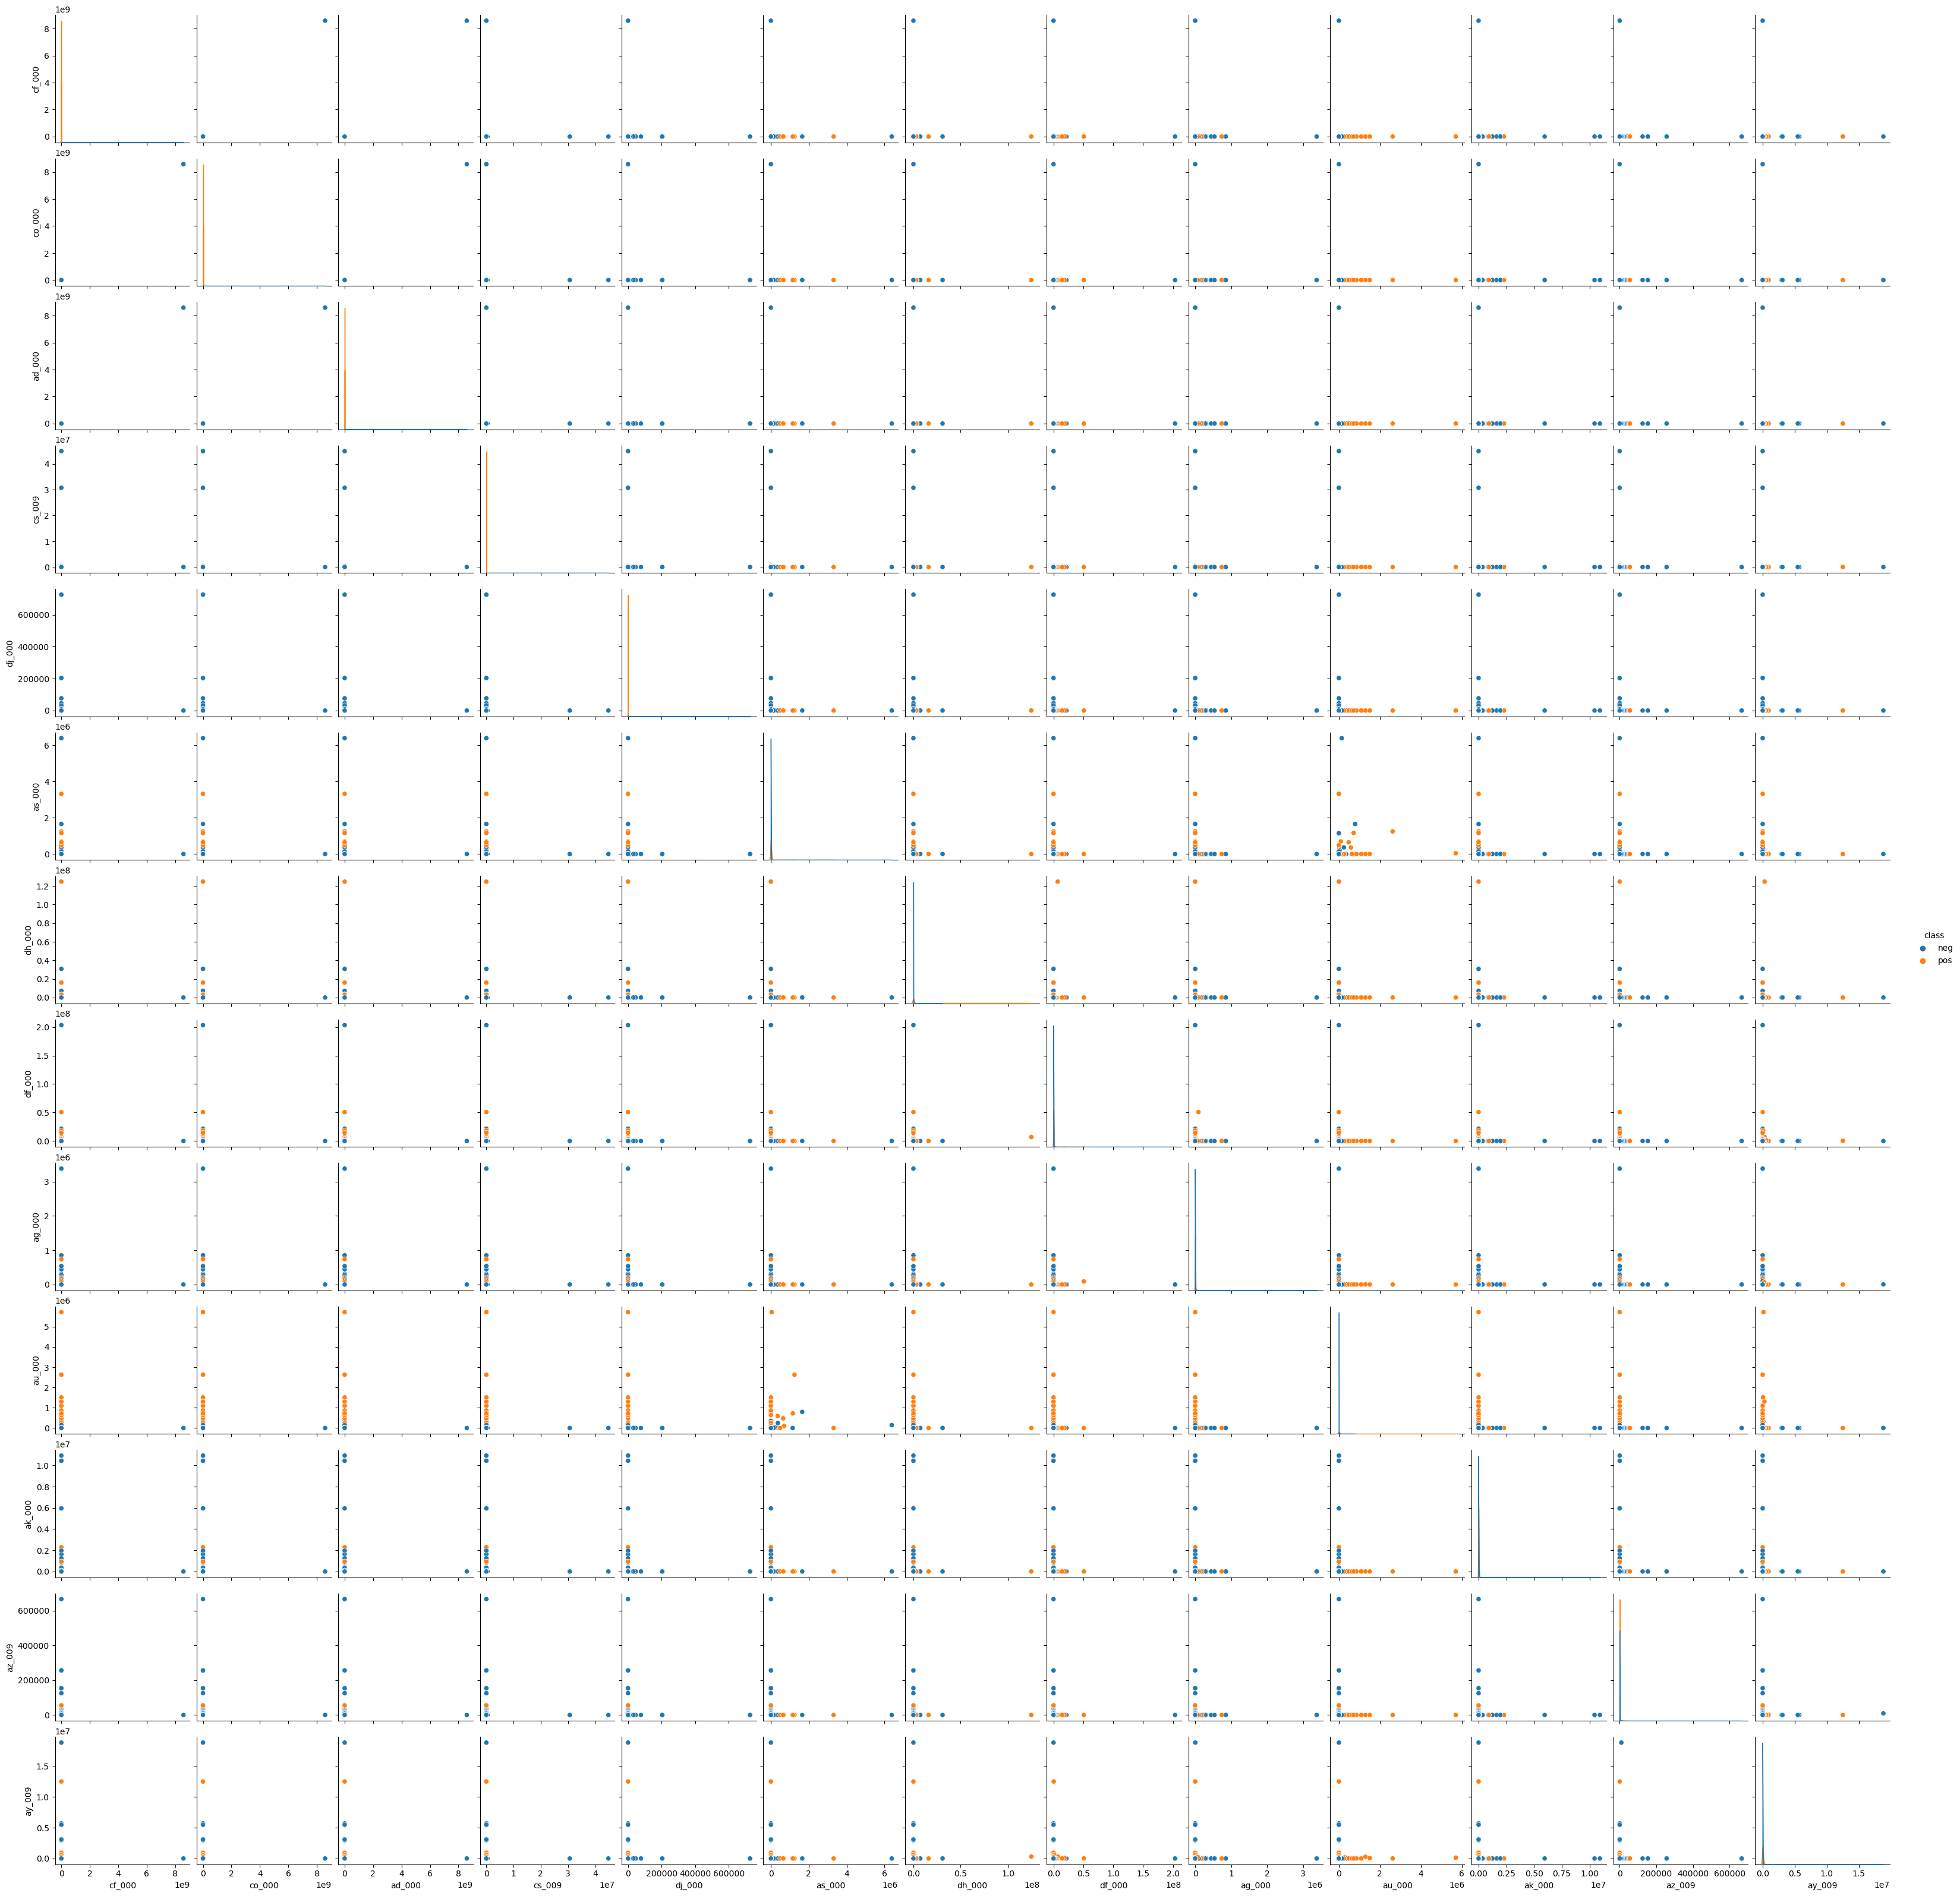

In [12]:
print('------------------------------------------------------------------------')
print('SCATTER PLOT OF 13 FEATURES')
print('------------------------------------------------------------------------')
apsTopN = round(math.sqrt(170))
sortedApsCVs = sorted(apsCVList.items(), key=operator.itemgetter(1), reverse=True)
apsPlotData = pd.DataFrame()
for i in range(0, apsTopN):
    featureName = sortedApsCVs[i][0]
    featureData = apsDataX[featureName][:]
    apsPlotData = pd.concat([apsPlotData, featureData], axis=1)
apsPlotData = pd.concat([apsPlotData, apsDataY], axis=1)

sb.pairplot(apsPlotData, hue='class')

# Findings:
This scatterplot depicts that classes are linearly separable for some of the feature pairs.

# Box plot of sqrt(170) features with highest CV.

BOX PLOT OF 13 FEATURES
---------------------------------


cf_000         AxesSubplot(0.1,0.736957;0.173913x0.163043)
co_000    AxesSubplot(0.308696,0.736957;0.173913x0.163043)
ad_000    AxesSubplot(0.517391,0.736957;0.173913x0.163043)
cs_009    AxesSubplot(0.726087,0.736957;0.173913x0.163043)
dj_000         AxesSubplot(0.1,0.541304;0.173913x0.163043)
as_000    AxesSubplot(0.308696,0.541304;0.173913x0.163043)
dh_000    AxesSubplot(0.517391,0.541304;0.173913x0.163043)
df_000    AxesSubplot(0.726087,0.541304;0.173913x0.163043)
ag_000         AxesSubplot(0.1,0.345652;0.173913x0.163043)
au_000    AxesSubplot(0.308696,0.345652;0.173913x0.163043)
ak_000    AxesSubplot(0.517391,0.345652;0.173913x0.163043)
az_009    AxesSubplot(0.726087,0.345652;0.173913x0.163043)
ay_009             AxesSubplot(0.1,0.15;0.173913x0.163043)
dtype: object

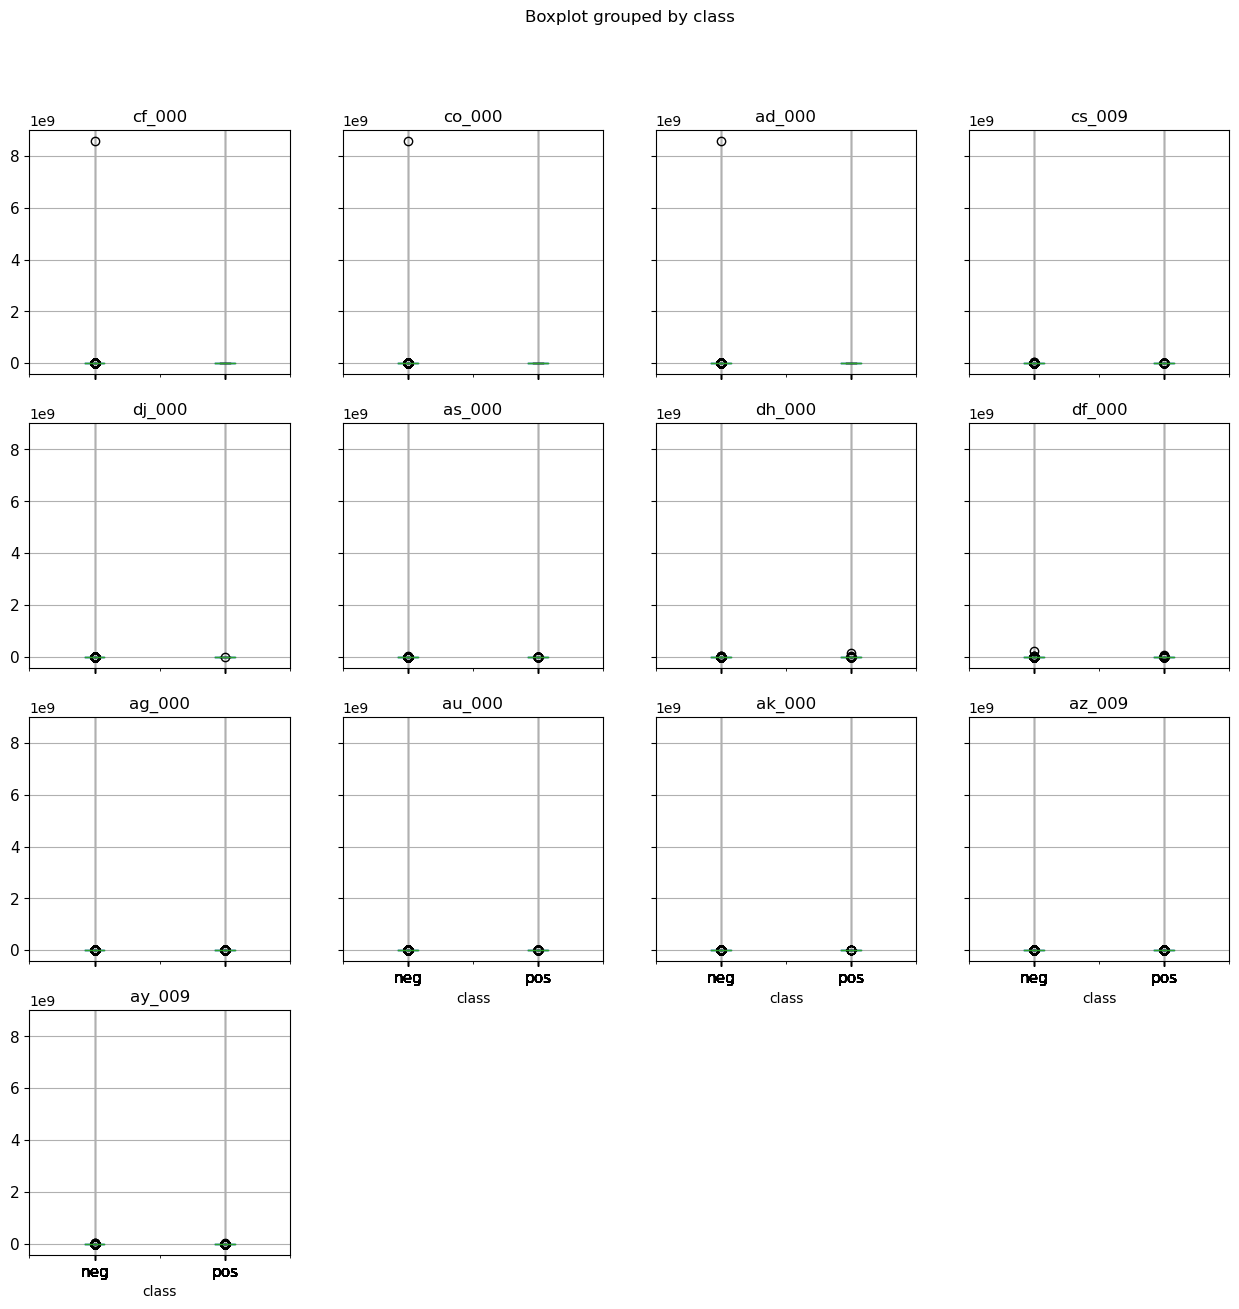

In [13]:
print('BOX PLOT OF 13 FEATURES')
print('---------------------------------')
columnNames = apsPlotData.columns
columns = []
for i in range(0, len(columnNames)-1):
    columns.append(columnNames[i])

apsPlotData.boxplot(column=columns, by='class', fontsize=11, figsize=(15, 15), return_type='axes')

# To check if the data is balanced

In [14]:
negTrain = 0
posTrain = 0
for i in range(0, len(actualTrainDataY)):
    if actualTrainDataY[i]==0:
        negTrain += 1
    else:
        posTrain += 1

print('TRAINING DATA:')
print('Positive class count:', posTrain)
print('Negative class count:', negTrain)

negTest = 0
posTest = 0
for i in range(0, len(actualTestDataY)):
    if actualTestDataY[i]==0:
        negTest += 1
    else:
        posTest += 1
print('------------------------------------')
print('TESTING DATA:')
print('Positive class count:', posTest)
print('Negative class count:', negTest)


TRAINING DATA:
Positive class count: 1000
Negative class count: 59000
------------------------------------
TESTING DATA:
Positive class count: 375
Negative class count: 15625


# Findings:
Yes, the data set is highly imbalanced because there are 74625 observations that belong to 'neg' class, and only 1375 observations belong to class 'pos'.

# 1. c) Train a random forest to classify the data set.

In [15]:
actualTrainDataY = list(actualTrainDataY)
actualTestDataY = list(actualTestDataY)

randomForestModel = RandomForestClassifier(n_estimators=100,oob_score = True)
randomForestModel = randomForestModel.fit(apsTrainDataX, actualTrainDataY)

rfTestPredictedY = randomForestModel.predict(apsTestDataX)
rfTrainPredictedY = randomForestModel.predict(apsTrainDataX)

rfTrainAccuracy = accuracy_score(actualTrainDataY, rfTrainPredictedY)
rfTrainAccuracy = round(rfTrainAccuracy, 3)
print('------------------------------------------------------------------------')
print("TRAIN ACCURACY OF RANDOM FOREST: ", rfTrainAccuracy)
print('------------------------------------------------------------------------')

rfTrainError = 1-rfTrainAccuracy
rfTrainError = round(rfTrainError, 3)
print("TRAIN ERROR OF RANDOM FOREST: ", rfTrainError)
print('------------------------------------------------------------------------')

rfTestAccuracy = accuracy_score(actualTestDataY, rfTestPredictedY)
rfTestAccuracy = round(rfTestAccuracy, 3)
print("TEST ACCURACY OF RANDOM FOREST: ", rfTestAccuracy)
print('------------------------------------------------------------------------')

rfTestError = 1-rfTestAccuracy
rfTestError = round(rfTestError, 3)
print("TEST ERROR OF RANDOM FOREST: ", rfTestError)
print('------------------------------------------------------------------------')

oobError = 1-randomForestModel.oob_score_
oobError = round(oobError, 3)
print('OUT OF BAG ERROR:', oobError)

------------------------------------------------------------------------
TRAIN ACCURACY OF RANDOM FOREST:  1.0
------------------------------------------------------------------------
TRAIN ERROR OF RANDOM FOREST:  0.0
------------------------------------------------------------------------
TEST ACCURACY OF RANDOM FOREST:  0.992
------------------------------------------------------------------------
TEST ERROR OF RANDOM FOREST:  0.008
------------------------------------------------------------------------
OUT OF BAG ERROR: 0.006


In [16]:
print('----------------------------------------------')
print('CONFUSION MATRIX FOR TRAIN DATA')
print('----------------------------------------------')
rfTrainConfusionMatrix = confusion_matrix(actualTrainDataY, rfTrainPredictedY)
RFTrainTN, RFTrainFP, RFTrainFN, RFTrainTP = rfTrainConfusionMatrix.ravel()
printConfusionMatrix(RFTrainTN, RFTrainFP, RFTrainFN, RFTrainTP)

print('----------------------------------------------')
print('CONFUSION MATRIX FOR TEST DATA')
print('----------------------------------------------')
rfTestConfusionMatrix = confusion_matrix(actualTestDataY, rfTestPredictedY)
RFTestTN, RFTestFP, RFTestFN, RFTestTP = rfTestConfusionMatrix.ravel()
printConfusionMatrix(RFTestTN, RFTestFP, RFTestFN, RFTestTP)

----------------------------------------------
CONFUSION MATRIX FOR TRAIN DATA
----------------------------------------------
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |     1000      |       0       |
+------------+---------------+---------------+
| Actual Neg |       0       |     59000     |
+------------+---------------+---------------+
----------------------------------------------
CONFUSION MATRIX FOR TEST DATA
----------------------------------------------
+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |      265      |      110      |
+------------+---------------+---------------+
| Actual Neg |      17       |     15608     |
+------------+---------------+---------------+


In [17]:

print("MISCLASSIFICATIONS FOR TRAIN DATA:")
print('----------------------------------------------')
print("TOTAL FALSE POSITIVES:", RFTrainFP)
print("TOTAL FALSE NEGATIVES:", RFTrainFN)
print("TOTAL MISCLASSIFICATIONS:", RFTrainFP+RFTrainFN)

print('\n')
print("MISCLASSIFICATIONS FOR TEST DATA:")
print('----------------------------------------------')
print("TOTAL FALSE POSITIVES:", RFTestFP)
print("TOTAL FALSE NEGATIVES:", RFTestFN)
print("TOTAL MISCLASSIFICATIONS:", RFTestFP+RFTestFN)


MISCLASSIFICATIONS FOR TRAIN DATA:
----------------------------------------------
TOTAL FALSE POSITIVES: 0
TOTAL FALSE NEGATIVES: 0
TOTAL MISCLASSIFICATIONS: 0


MISCLASSIFICATIONS FOR TEST DATA:
----------------------------------------------
TOTAL FALSE POSITIVES: 17
TOTAL FALSE NEGATIVES: 110
TOTAL MISCLASSIFICATIONS: 127


ROC FOR TRAIN DATA:


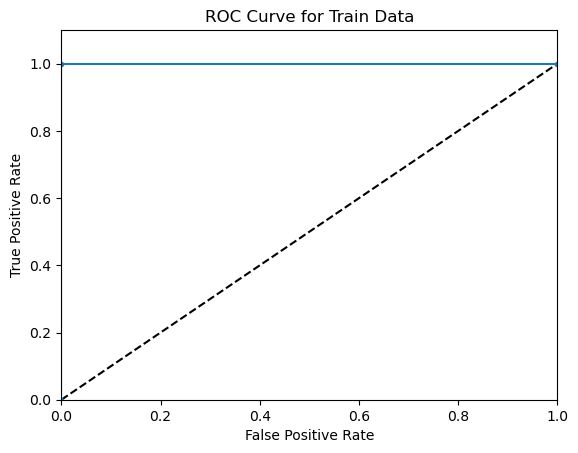

AUC FOR TRAIN DATA: 1.0




ROC FOR TEST DATA:


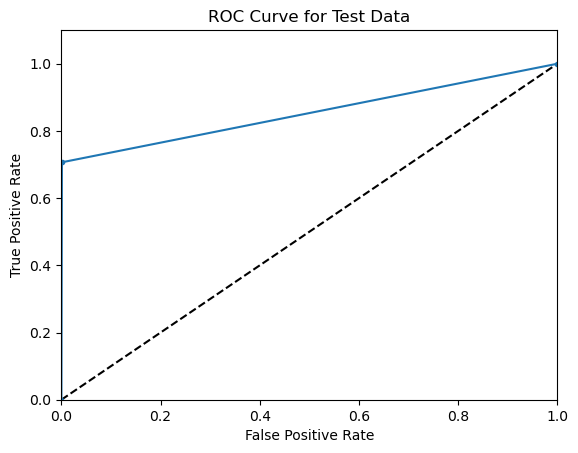


AUC FOR TEST DATA: 0.853



In [18]:
RFTrainFPR, RFTrainTPR, RFTrainThreshold = roc_curve(actualTrainDataY, rfTrainPredictedY)
RFTrainAUC = round(roc_auc_score(actualTrainDataY, rfTrainPredictedY), 3)

print("ROC FOR TRAIN DATA:")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(RFTrainFPR, RFTrainTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()

print("AUC FOR TRAIN DATA:", RFTrainAUC)
print('\n')

RFTestFPR, RFTestTPR, RFTestThreshold = roc_curve(actualTestDataY, rfTestPredictedY)
RFTestAUC = round(roc_auc_score(actualTestDataY, rfTestPredictedY), 3)

print('\n')
print("ROC FOR TEST DATA:")
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(RFTestFPR, RFTestTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('')
print("AUC FOR TEST DATA:", RFTestAUC)
print('')

# 1. d) Random Forest Classifier for Class Imbalance Data.

In [19]:
balancedRFModel = RandomForestClassifier(n_estimators=100, oob_score = True, class_weight='balanced')
balancedRFModel = balancedRFModel.fit(apsTrainDataX, actualTrainDataY)

balancedRFTestPredY = balancedRFModel.predict(apsTestDataX)
balancedRFTrainPredY = balancedRFModel.predict(apsTrainDataX)

balancedRFTrainAccuracy = accuracy_score(actualTrainDataY, balancedRFTrainPredY)
balancedRFTrainAccuracy = round(balancedRFTrainAccuracy, 3)
print('RESULTS AFTER BALANCING CLASSES:')
print('------------------------------------------------------------------------')
print("TRAIN ACCURACY OF RANDOM FOREST: ", balancedRFTrainAccuracy)
print('')

balancedRFTrainError = 1-balancedRFTrainAccuracy
balancedRFTrainError = round(balancedRFTrainError, 3)
print("TRAIN ERROR OF RANDOM FOREST: ", balancedRFTrainError)
print('')

balancedRFTestAccuracy = accuracy_score(actualTestDataY, balancedRFTestPredY)
balancedRFTestAccuracy = round(balancedRFTestAccuracy, 3)
print("TEST ACCURACY OF RANDOM FOREST: ", balancedRFTestAccuracy)
print('')

balancedRFTestError = 1-balancedRFTestAccuracy
balancedRFTestError = round(balancedRFTestError, 3)
print("TEST ERROR OF RANDOM FOREST: ", balancedRFTestError)
print('')

balancedOOBError = 1-balancedRFModel.oob_score_
balancedOOBError = round(balancedOOBError, 3)
print('OUT OF BAG ERROR:', balancedOOBError)

RESULTS AFTER BALANCING CLASSES:
------------------------------------------------------------------------
TRAIN ACCURACY OF RANDOM FOREST:  1.0

TRAIN ERROR OF RANDOM FOREST:  0.0

TEST ACCURACY OF RANDOM FOREST:  0.989

TEST ERROR OF RANDOM FOREST:  0.011

OUT OF BAG ERROR: 0.008


In [20]:
print('')
print('CONFUSION MATRIX FOR TRAIN DATA')
print('')
balancedRFTrainConfusionMatrix = confusion_matrix(actualTrainDataY, balancedRFTrainPredY)
BRFTrainTN, BRFTrainFP, BRFTrainFN, BRFTrainTP = balancedRFTrainConfusionMatrix.ravel()
printConfusionMatrix(BRFTrainTN, BRFTrainFP, BRFTrainFN, BRFTrainTP)

print('')
print('CONFUSION MATRIX FOR TEST DATA')
print('')
balancedRFTestConfusionMatrix = confusion_matrix(actualTestDataY, balancedRFTestPredY)
BRFTestTN, BRFTestFP, BRFTestFN, BRFTestTP = balancedRFTestConfusionMatrix.ravel()
printConfusionMatrix(BRFTestTN, BRFTestFP, BRFTestFN, BRFTestTP)


CONFUSION MATRIX FOR TRAIN DATA

+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |     1000      |       0       |
+------------+---------------+---------------+
| Actual Neg |       0       |     59000     |
+------------+---------------+---------------+

CONFUSION MATRIX FOR TEST DATA

+============+===============+===============+
|            | Predicted Pos | Predicted Neg |
+------------+---------------+---------------+
| Actual Pos |      215      |      160      |
+------------+---------------+---------------+
| Actual Neg |      10       |     15615     |
+------------+---------------+---------------+


In [21]:
print("MISCLASSIFICATIONS FOR TRAIN DATA:")
print('----------------------------------------------')
print("TOTAL FALSE POSITIVES:", BRFTrainFP)
print("TOTAL FALSE NEGATIVES:", BRFTrainFN)
print("TOTAL MISCLASSIFICATIONS:", BRFTrainFP+BRFTrainFN)

print("MISCLASSIFICATIONS FOR TEST DATA:")
print('----------------------------------------------')
print("TOTAL FALSE POSITIVES:", BRFTestFP)
print("TOTAL FALSE NEGATIVES:", BRFTestFN)
print("TOTAL MISCLASSIFICATIONS:", BRFTestFP+BRFTestFN)

MISCLASSIFICATIONS FOR TRAIN DATA:
----------------------------------------------
TOTAL FALSE POSITIVES: 0
TOTAL FALSE NEGATIVES: 0
TOTAL MISCLASSIFICATIONS: 0
MISCLASSIFICATIONS FOR TEST DATA:
----------------------------------------------
TOTAL FALSE POSITIVES: 10
TOTAL FALSE NEGATIVES: 160
TOTAL MISCLASSIFICATIONS: 170



ROC FOR TRAIN DATA:
----------------------------------------------


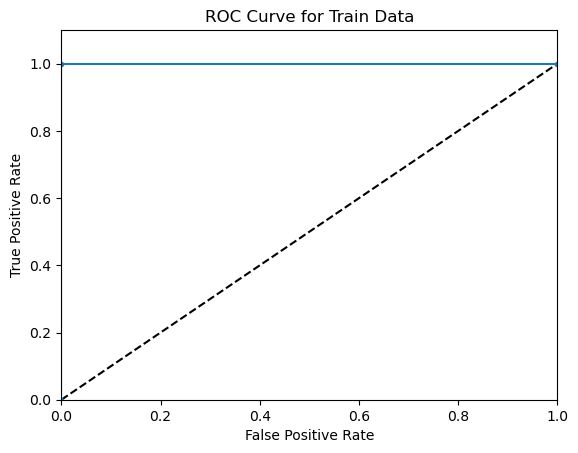


AUC FOR TRAIN DATA: 1.0
----------------------------------------------

ROC FOR TEST DATA:



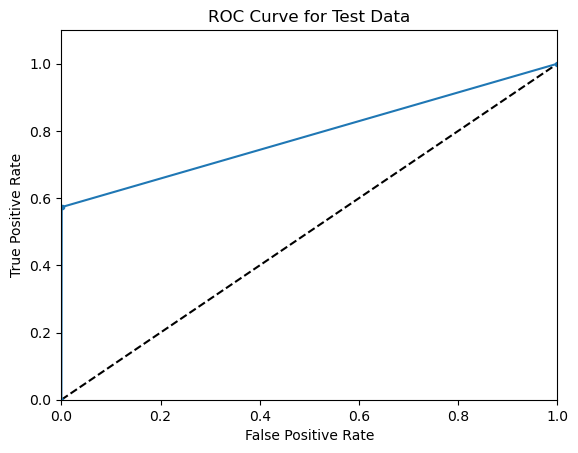


AUC FOR TEST DATA: 0.786


In [22]:
BRFTrainFPR, BRFTrainTPR, BRFTrainThreshold = roc_curve(actualTrainDataY, balancedRFTrainPredY)
BRFTrainAUC = round(roc_auc_score(actualTrainDataY, balancedRFTrainPredY), 3)

print('')
print("ROC FOR TRAIN DATA:")
print('----------------------------------------------')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(BRFTrainFPR, BRFTrainTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Train Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('')
print("AUC FOR TRAIN DATA:", BRFTrainAUC)
print('----------------------------------------------')


BRFTestFPR, BRFTestTPR, BRFTestThreshold = roc_curve(actualTestDataY, balancedRFTestPredY)
BRFTestAUC = round(roc_auc_score(actualTestDataY, balancedRFTestPredY), 3)

print('')
print("ROC FOR TEST DATA:")
print('')
plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.plot(BRFTestFPR, BRFTestTPR, marker='.')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve for Test Data")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.1])
plt.show()
print('')
print("AUC FOR TEST DATA:", BRFTestAUC)

In [23]:
tableData = []
row = []
row.append('Train Accuracy')
row.append(rfTrainAccuracy)
row.append(balancedRFTrainAccuracy)
tableData.append(row)
row = []
row.append('Test Accuracy')
row.append(rfTestAccuracy)
row.append(balancedRFTestAccuracy)
tableData.append(row)
row = []
row.append('OOB Error')
row.append(oobError)
row.append(balancedOOBError)
tableData.append(row)
row = []
row.append('Test Error')
row.append(rfTestError)
row.append(balancedRFTestError)
tableData.append(row)
row = []
row.append('Train AUC')
row.append(RFTrainAUC)
row.append(BRFTrainAUC)
tableData.append(row)
row = []
row.append('Test AUC')
row.append(RFTestAUC)
row.append(BRFTestAUC)
tableData.append(row)
tableHeaders = ['Measure', 'Random Forest with Class Imbalance', 'Random Forest without Class Imbalance']
printDatainTable(tableHeaders, tableData)

+================+====================================+=======================================+
|    Measure     | Random Forest with Class Imbalance | Random Forest without Class Imbalance |
+================+====================================+=======================================+
| Train Accuracy |                1.0                 |                  1.0                  |
+----------------+------------------------------------+---------------------------------------+
| Test Accuracy  |               0.992                |                 0.989                 |
+----------------+------------------------------------+---------------------------------------+
|   OOB Error    |               0.006                |                 0.008                 |
+----------------+------------------------------------+---------------------------------------+
|   Test Error   |               0.008                |                 0.011                 |
+----------------+----------------------

# Findings:
It is clear from the results that resampling has increased the accuracy of test data for Random Forest.

In [24]:
def get_X_Y_split(df):
    x_data = df.iloc[:, 1:]
    y_data = df.iloc[:, 0:1]
    return x_data, y_data

In [25]:
from sklearn.impute import SimpleImputer

def impute(df):
    imputer = SimpleImputer(strategy='mean', missing_values=np.nan)
    temp1 = imputer.fit_transform(df)
    imputed_df = pd.DataFrame(temp1, columns=df.columns)
    return imputed_df

In [26]:
def calculate_model_summary(ground_truth, predicted_truth, prob, title, is_for_xgboost=False):
    calculate_accuracy_score(ground_truth, predicted_truth)
    calculate_confusion_matrix(ground_truth, predicted_truth)
    if is_for_xgboost:
        get_roc_auc_score(ground_truth, predicted_truth)
    plot_roc_curve(ground_truth, prob, title, is_for_xgboost)

In [27]:
def calculate_confusion_matrix(ground_truth, predicted_truth):
    conf_matrix = confusion_matrix(ground_truth, predicted_truth)
    print(f'Confusion Matrix is: \n{conf_matrix}')
    print("\n")

In [28]:
def calculate_accuracy_score(ground_truth, predicted_truth):
    calculated_accuracy_score = accuracy_score(ground_truth, predicted_truth)
    print(f'Accuracy Score is: {round(calculated_accuracy_score, 4)}')
    print("\n")

In [29]:
def get_roc_auc_score(ground_truth, predicted_truth):
    calculated_roc_auc_score = roc_auc_score(ground_truth, predicted_truth)
    print(f'ROC AUC Score is: {round(calculated_roc_auc_score, 4)}')
    print("\n")

In [30]:
def plot_roc_curve(actualY, predictedY_prob, title, is_for_xgboost=False):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title(f"ROC curves for {title}")
    y_predicted = predictedY_prob[:, 1]
    if not is_for_xgboost:
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted, pos_label='pos')
    else:
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted)
    roc_auc = auc(fpr, tpr)
    axes.plot(fpr, tpr, label=f"ROC Curve Area: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

In [31]:
def fit_random_forest(data_x, data_y, is_balanced=False):
    if not is_balanced:
        RF_model = RandomForestClassifier(max_depth=5, 
                                          random_state=60000,
                                          oob_score=True)
    else:
        RF_model = RandomForestClassifier(max_depth=5, 
                                          random_state=60000,
                                          class_weight='balanced',
                                          oob_score=True)
    RF_model.fit(data_x, data_y)
    return RF_model

# 1. e) XGBoost and Model Trees

In [32]:
aps_train_df_x, aps_train_df_y = get_X_Y_split(apsTrainData)
aps_test_df_x, aps_test_df_y = get_X_Y_split(apsTestData) 

imputed_aps_train_df_x = impute(aps_train_df_x) 
imputed_aps_test_df_x = impute(aps_test_df_x) 

In [33]:
ss = StandardScaler()
train_x_cols = imputed_aps_train_df_x.columns
test_x_cols = imputed_aps_test_df_x.columns
x_train = pd.DataFrame(ss.fit_transform(imputed_aps_train_df_x),columns=train_x_cols)
x_test = pd.DataFrame(ss.fit_transform(imputed_aps_test_df_x),columns=test_x_cols)
estimator = XGBClassifier(objective='binary:logistic',
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          use_label_encoder=False)
param_grid = {
    "reg_alpha": [0.01, 0.05,0.07,0.08,0.09, 0.1, 0.2, 0.5, 0.75, 1, 2, 3, 4, 5, 10, 20, 50, 100, 200]
}
aps_test_df_y['class'].replace({'neg':0,'pos':1},inplace=True)
aps_train_df_y 

class
0       neg
1       neg
2       neg
3       neg
4       neg
...     ...
59995   neg
59996   neg
59997   neg
59998   neg
59999   neg

[60000 rows x 1 columns]

In [34]:
cv = KFold(n_splits=5,shuffle=True,random_state=11)
grid_cv = GridSearchCV(estimator, 
                       param_grid, 
                       n_jobs=-1, 
                       cv=cv, 
                       scoring="accuracy")
aps_train_df_y['class'].replace({'neg':0,'pos':1},inplace=True)
grid_cv.fit(x_train, aps_train_df_y)

GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inte...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'reg_alpha': [0.01, 0.05, 0.07, 0.08, 0.09, 0.1, 0.2,
                                       0.5, 0.75, 1, 2, 3, 4, 5, 10, 20, 50,
                                       100, 200]},
             scoring='accuracy')

In [35]:
print('The best alpha is ',grid_cv.best_params_, ' with a cross validation accuracy of ',round(grid_cv.best_score_,4))

The best alpha is  {'reg_alpha': 0.2}  with a cross validation accuracy of  0.9941


In [36]:
alpha_to_use = grid_cv.best_params_['reg_alpha']
estimator = XGBClassifier(objective='binary:logistic',
                          reg_alpha=alpha_to_use,
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          use_label_encoder=False,)
estimator.fit(x_train, aps_train_df_y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy Score is: 0.9982


Confusion Matrix is: 
[[58994     6]
 [  104   896]]


ROC AUC Score is: 0.9479




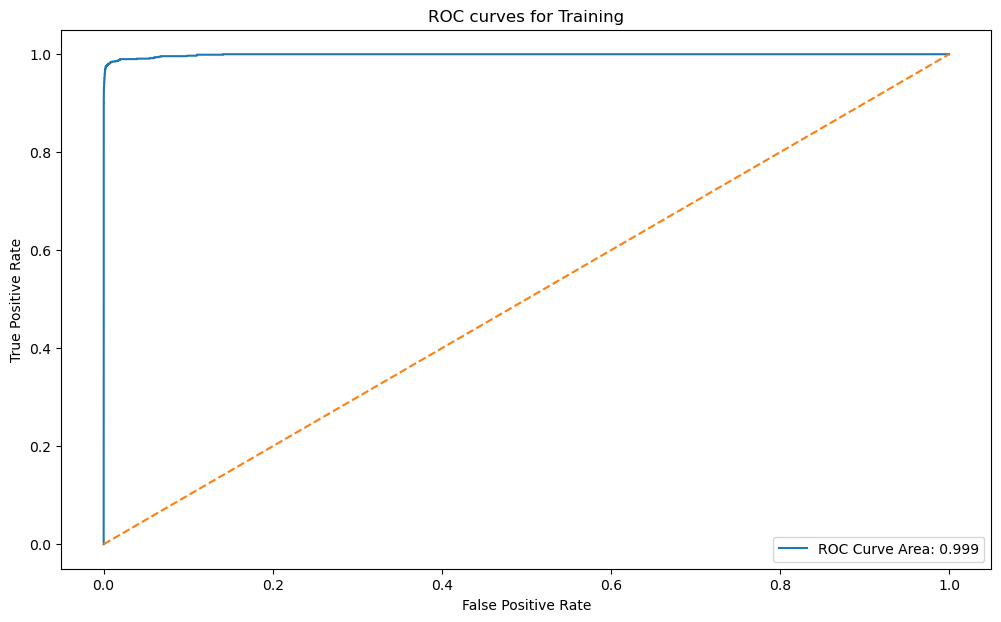

In [37]:
y_train_pred = estimator.predict(x_train)
y_train_pred_prob = estimator.predict_proba(x_train)

y_test_pred = estimator.predict(x_test)
y_test_pred_prob = estimator.predict_proba(x_test)
calculate_model_summary(aps_train_df_y.values, y_train_pred, y_train_pred_prob, "Training", is_for_xgboost=True)

Accuracy Score is: 0.9909


Confusion Matrix is: 
[[15590    35]
 [  111   264]]


ROC AUC Score is: 0.8509




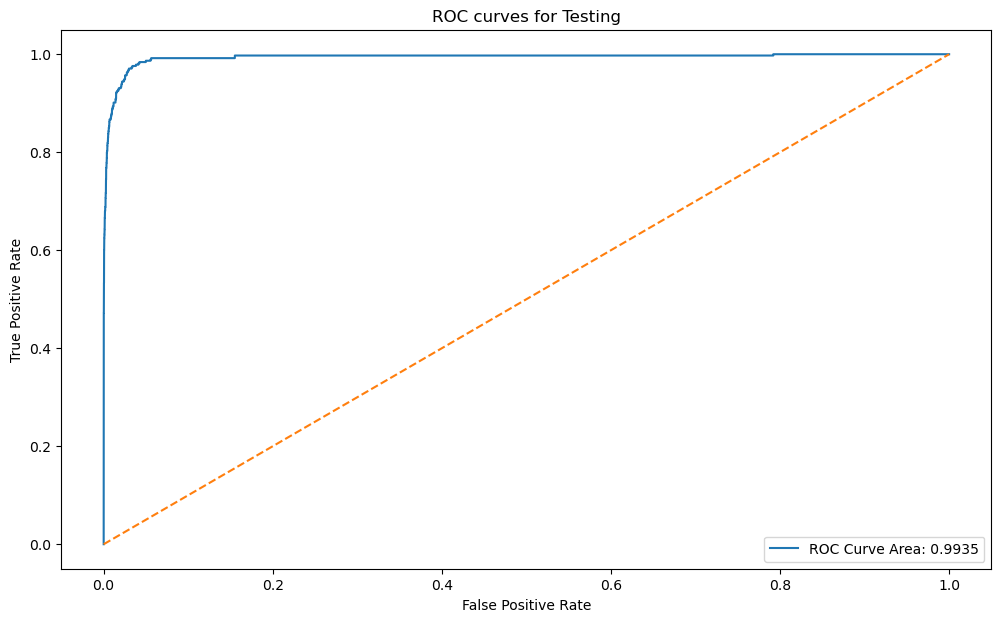

In [38]:
calculate_model_summary(aps_test_df_y, y_test_pred, y_test_pred_prob, "Testing", is_for_xgboost=True)


# 1. f) SMOTE

In [39]:
y_train = aps_train_df_y
y_test = aps_test_df_y
y_train

class
0          0
1          0
2          0
3          0
4          0
...      ...
59995      0
59996      0
59997      0
59998      0
59999      0

[60000 rows x 1 columns]

In [40]:
smote = SMOTE()
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

In [41]:
estimator

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [42]:
data = {
    "Before SMOTE": y_train.value_counts(),
    "After SMOTE": y_train_smote.value_counts()
}

df = pd.DataFrame(data=data)
df

Before SMOTE  After SMOTE
class                           
0             59000        59000
1              1000        59000

In [43]:
cv = KFold(n_splits=5,shuffle=True,random_state=11)
grid_smote = GridSearchCV(estimator, 
                       param_grid, 
                       n_jobs=-1, 
                       cv=cv, 
                       scoring="accuracy")
grid_smote.fit(x_train_smote, y_train_smote)

GridSearchCV(cv=KFold(n_splits=5, random_state=11, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.3,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     inte...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'reg_alpha': [0.01, 0.05, 0.07, 0.08, 0.09, 0.1, 0.2,
                                       0.5, 0.75, 1, 2, 3, 4, 5, 10, 20, 50,
                                       100, 200]},
             scoring='accuracy')

In [44]:
print('The best alpha is ',grid_smote.best_params_, ' with a cross validation accuracy of ',round(grid_smote.best_score_,4))

The best alpha is  {'reg_alpha': 0.01}  with a cross validation accuracy of  0.9944


In [45]:
alpha_value = grid_smote.best_params_['reg_alpha']

estimator_smote = XGBClassifier(objective='binary:logistic',
                          reg_alpha=alpha_value,
                          colsample_bytree = 0.3, 
                          learning_rate = 0.1,
                          max_depth = 5,
                          use_label_encoder=False,)
y_train['class'].replace({'neg':0,'pos':1},inplace=True)
estimator_smote.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy Score is: 0.9982


Confusion Matrix is: 
[[58997     3]
 [  103   897]]


ROC AUC Score is: 0.9485




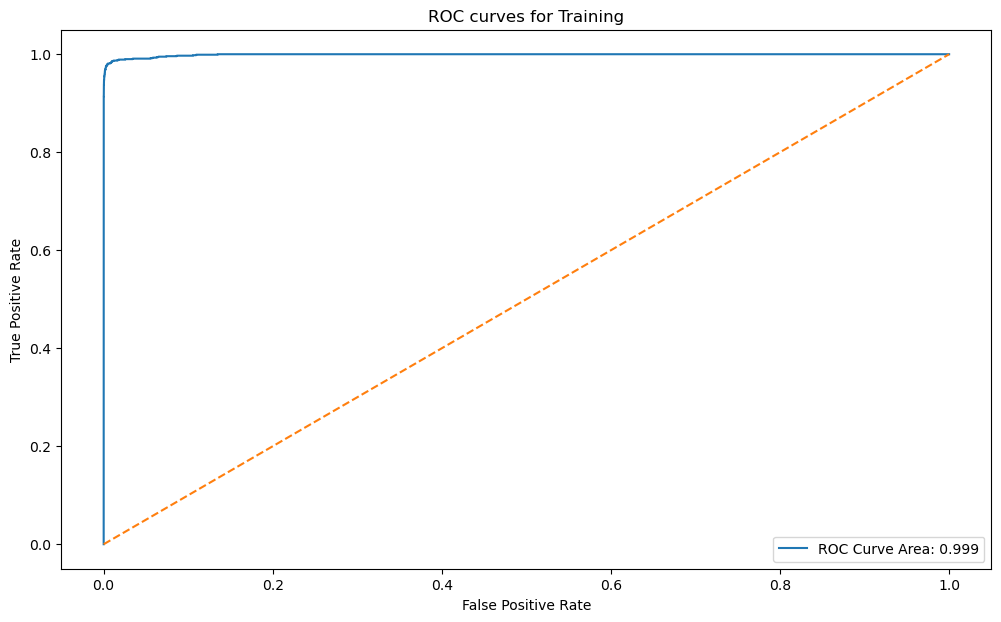

In [46]:
y_train_pred = estimator_smote.predict(x_train)
y_train_pred_prob = estimator_smote.predict_proba(x_train)

y_test_pred = estimator_smote.predict(x_test)
y_test_pred_prob = estimator_smote.predict_proba(x_test)
calculate_model_summary(y_train.values, y_train_pred, y_train_pred_prob, "Training", is_for_xgboost=True)

Accuracy Score is: 0.9917


Confusion Matrix is: 
[[15597    28]
 [  105   270]]


ROC AUC Score is: 0.8591




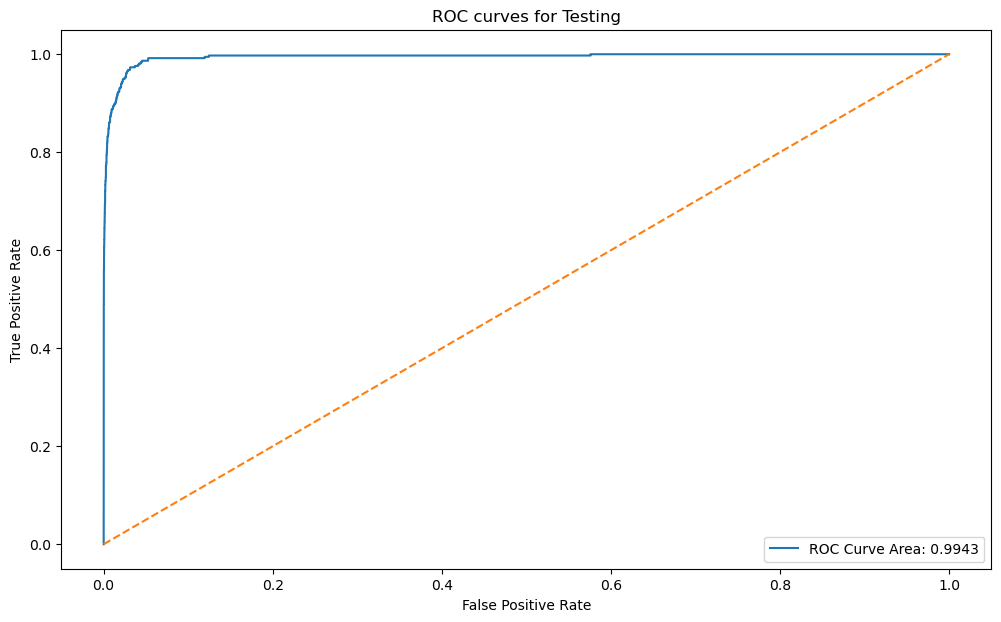

In [47]:
calculate_model_summary(y_test, y_test_pred, y_test_pred_prob, "Testing", is_for_xgboost=True)

# 2. ISLR 6.6.3
Suppose we estimate the regression coefficients in a linear regression model by minimizing for a particular value of s. For parts (a) through (e), indicate which of i. through v. is correct. Justify your answer.

(a) As we increase s from 0, the training RSS will: i. Increase initially, and then eventually start decreasing in an inverted U shape.
ii. Decrease initially, and then eventually start increasing in a U shape.
iii. Steadily increase.
iv. Steadily decrease.
v. Remain constant.

Ans: Steadily Decrease: The value of the estimated coefficients will go from 0 to their OLS value when the value of s increases. This is the reason that training RSS will decrease steadily.



(b) Repeat (a) for test RSS.

Ans: Decrease Initially and then eventually starts increasing in a new shape. The test RSS will decrease to a certain level after which it will hit an inflection point and the test residual sum error will start to increase.



(c) Repeat (a) for variance.

Ans: Steadily Increases: 
 is almost zero in the beginning which would mean that there is almost no variance in the beginning. It is only after the module becomes flexible does the variance start to go up.



(d) Repeat (a) for (squared) bias.

Ans: Steadily Decrease: Due to the bias-variance trade-off, since the variance is increasing, the bias will decrease.



(e) Repeat (a) for the irreducible error.

Ans: Irreducible error is act of god and is present in any machine learning model that is built and hence it will remain constant.



# 3. ISLR 6.6.5

# 
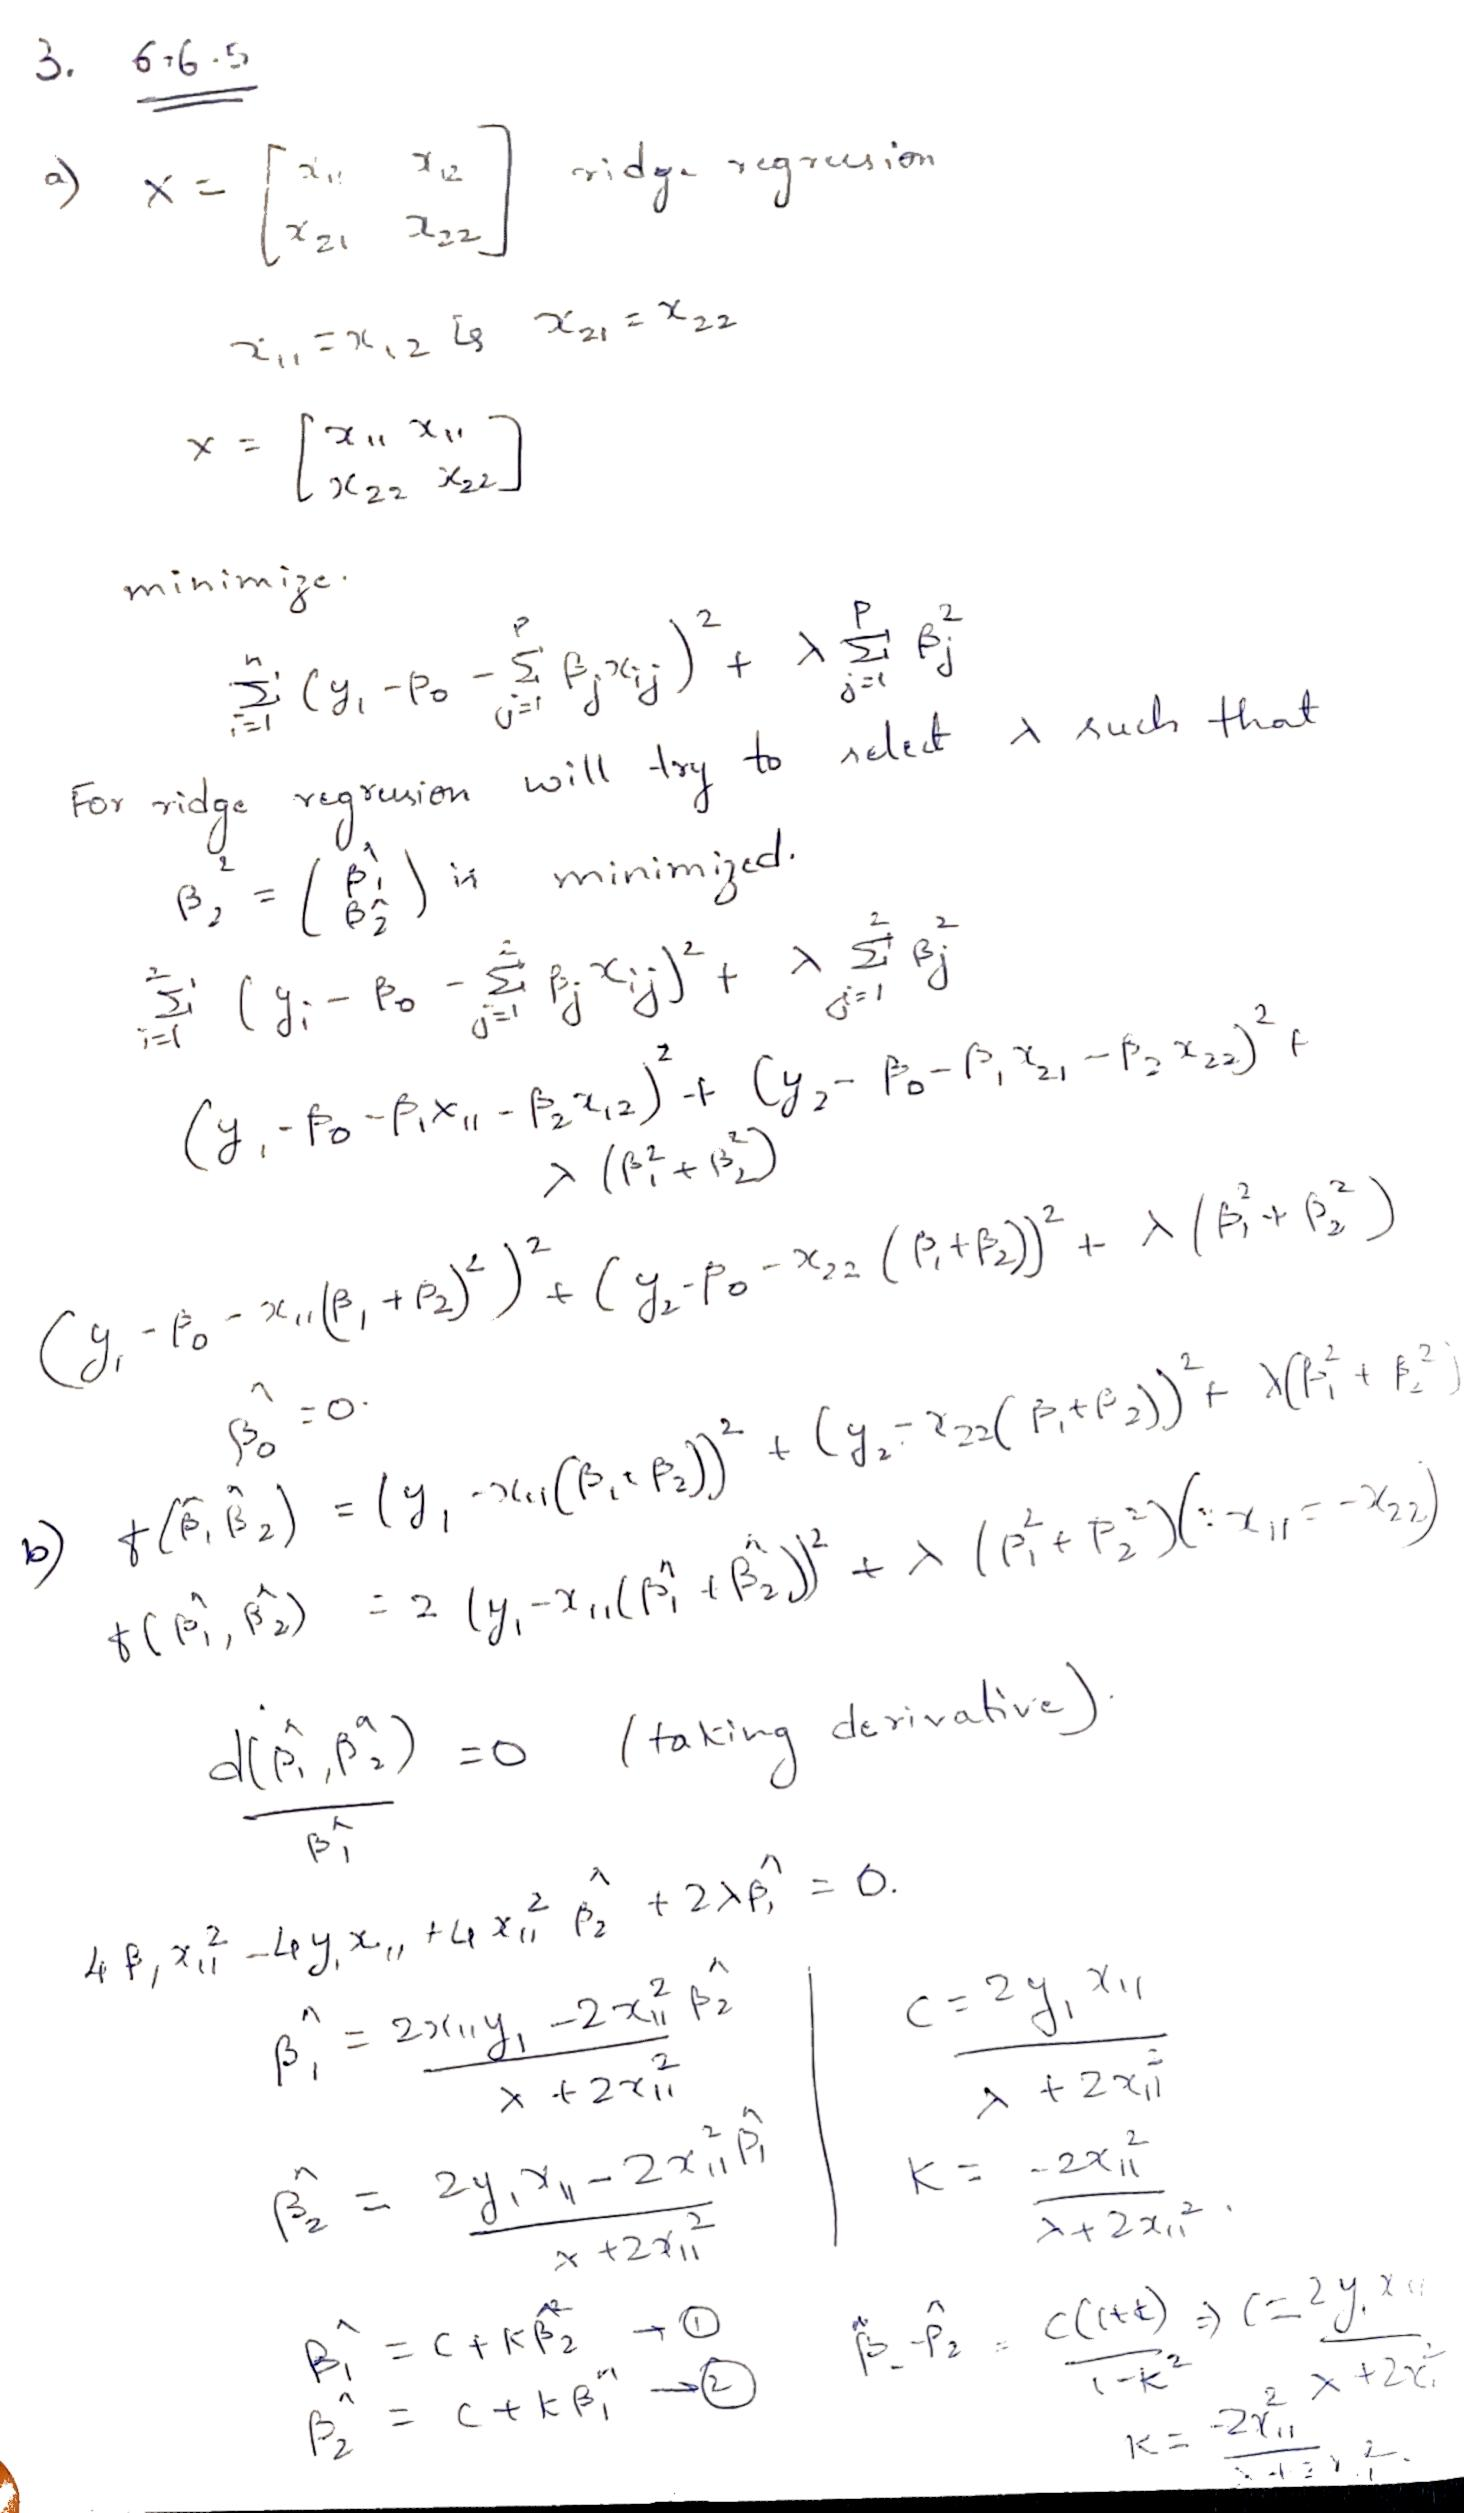

# 
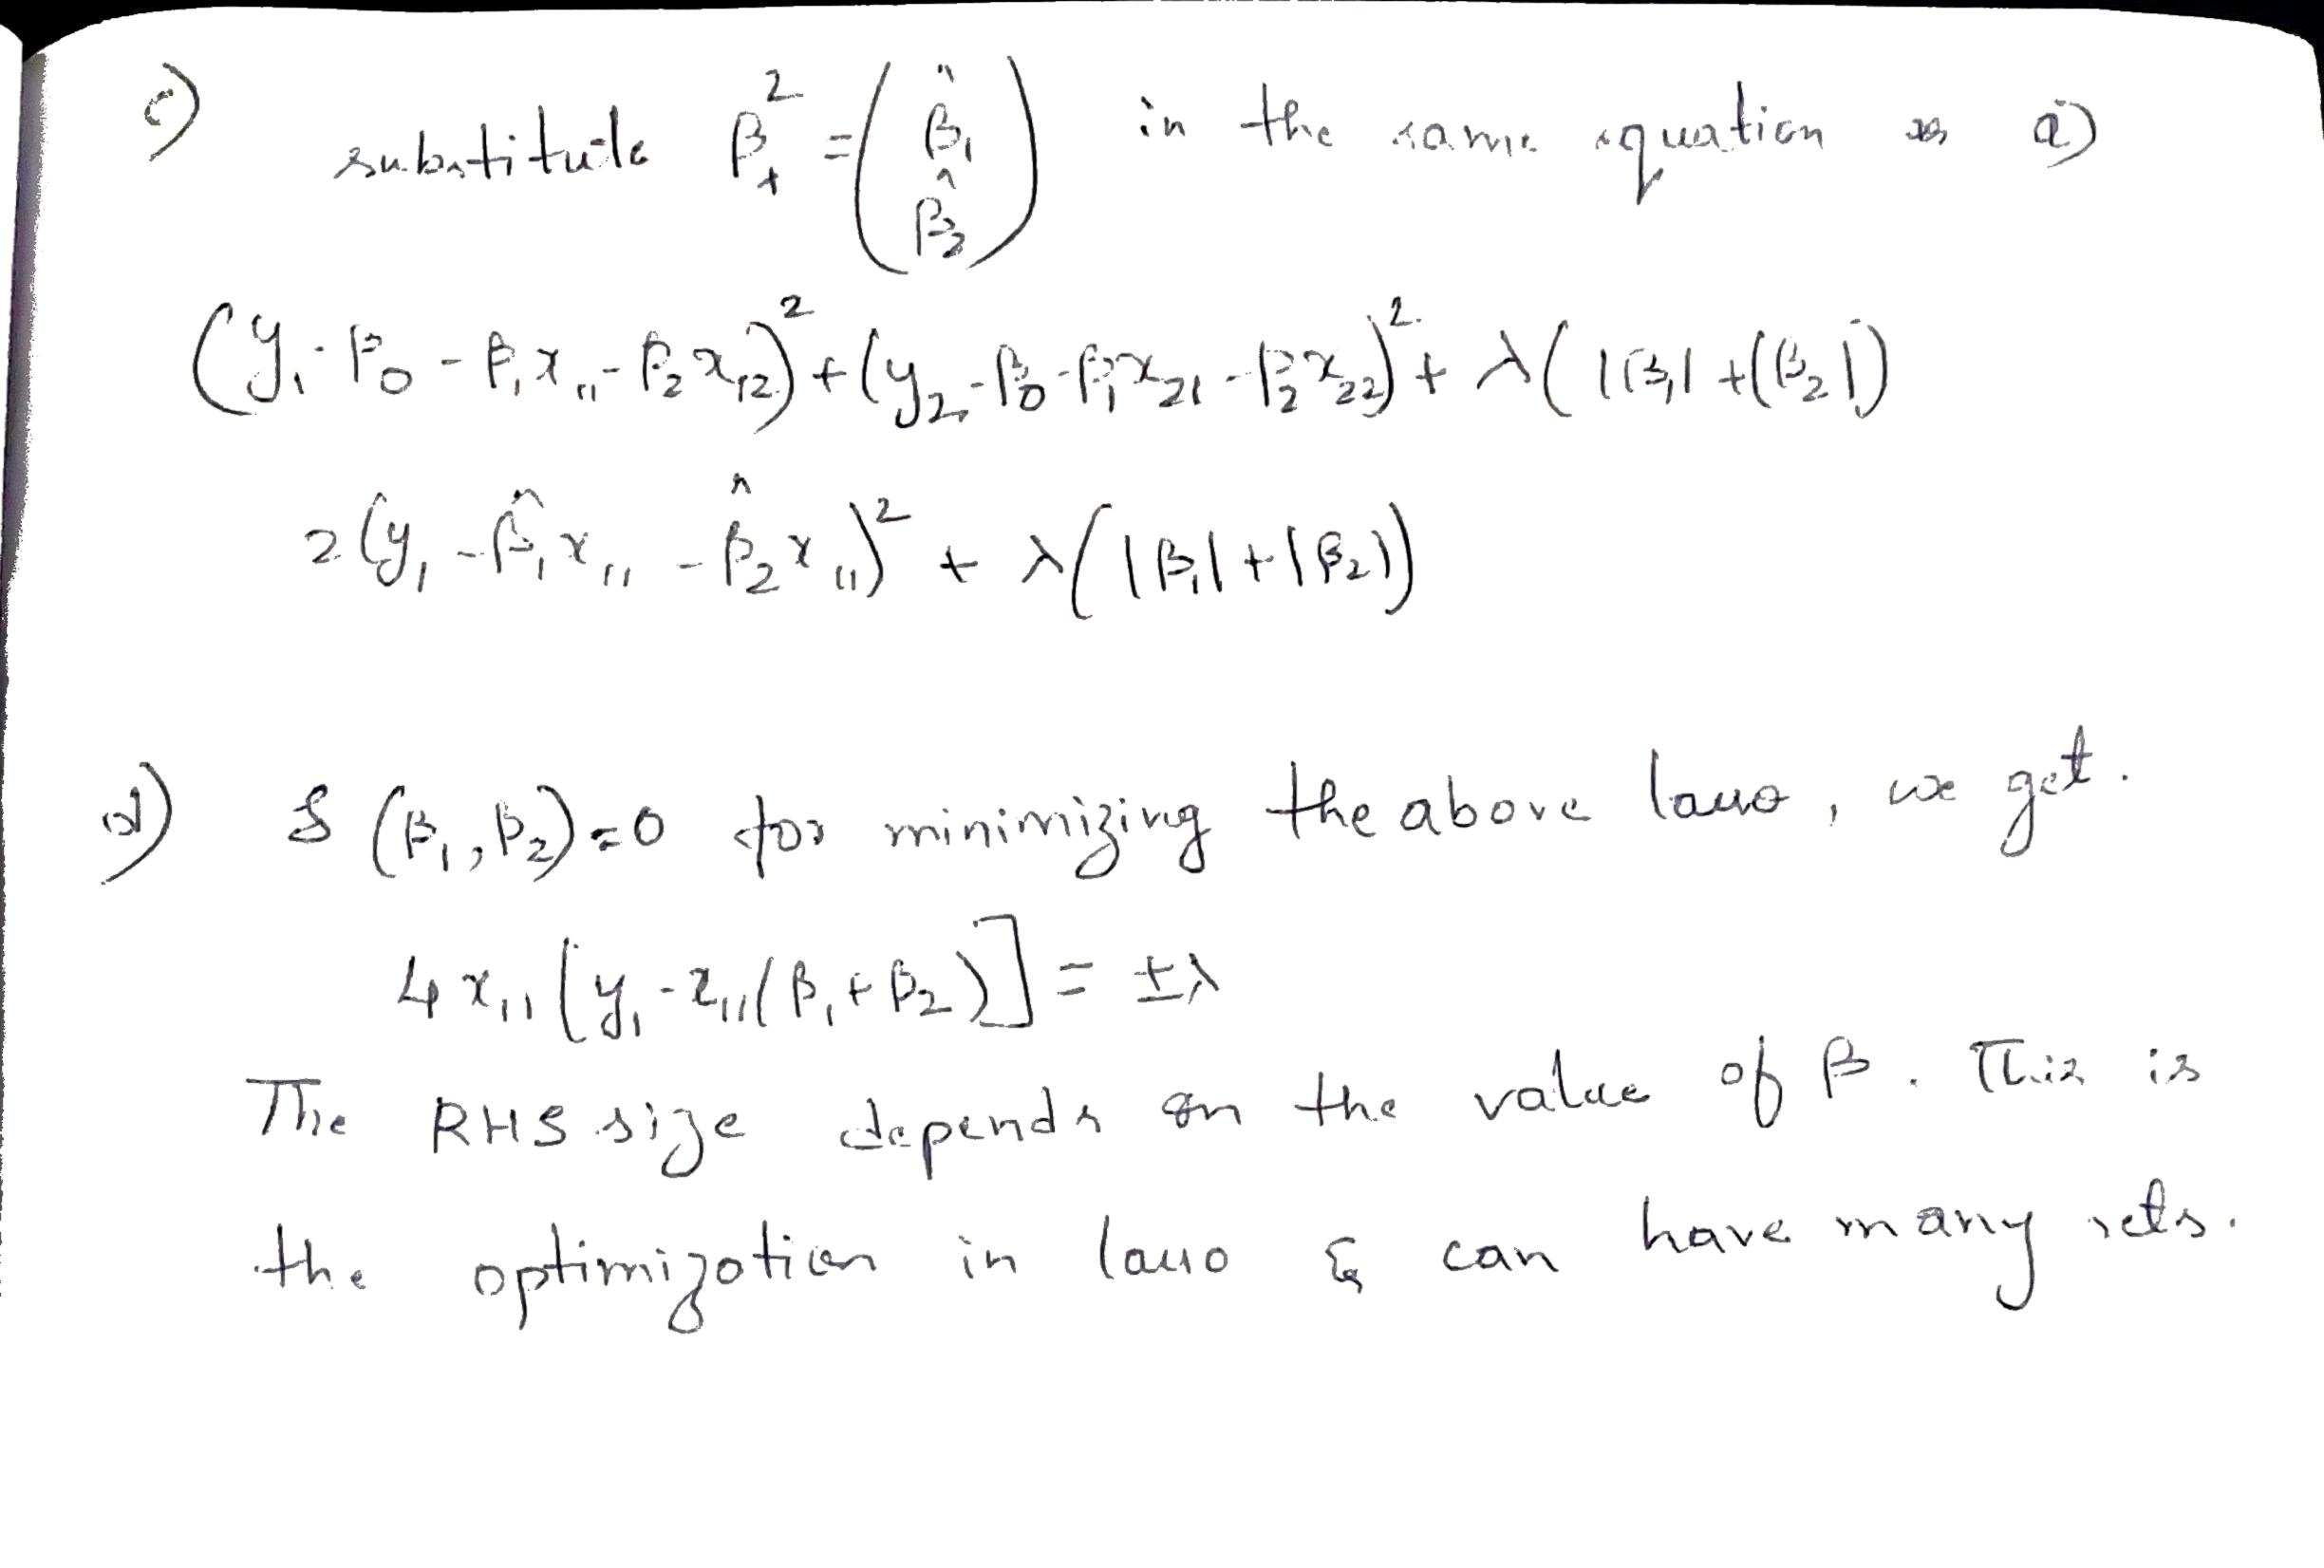

# 4. ISLR 8.4.5

Ans: Majority Polling: In this, probabilities >= 0.5 will be true and the classification will be false otherwise. False = 4 and True = 6 and hence, the red samples are larger than green samples and so the classification will be red class.


Ans: Average Probability: Mean for given probabilities = 0.45 hence the final prediction is green.

# 5. ISLR 9.7.3
Here we explore the maximal margin classifier on a toy data set.
(a) We are given 
 observations in 
 dimensions. For each observation, there is an associated class label. Sketch the observations



In [48]:
data={'X1':[3,2,4,1,2,4,4],'X2':[4,2,4,4,1,3,1],'Y':['red','red','red','red','blue','blue','blue']}
df = pd.DataFrame(data)
df

X1  X2     Y
0   3   4   red
1   2   2   red
2   4   4   red
3   1   4   red
4   2   1  blue
5   4   3  blue
6   4   1  blue

<AxesSubplot:xlabel='X1', ylabel='X2'>

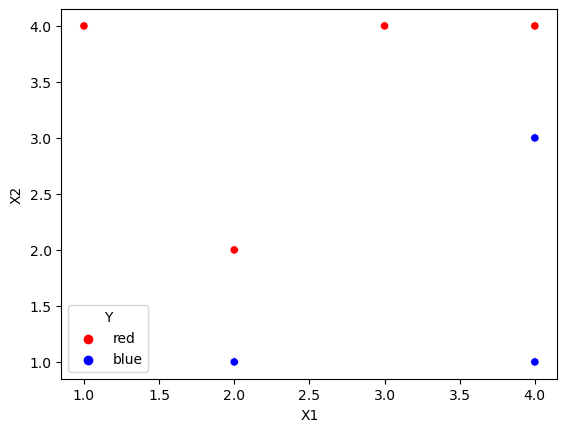

In [49]:
sb.scatterplot(data=df, x="X1", y="X2", hue="Y", palette=['red', 'blue'])

In [50]:
df['Y'].replace({'red': 0, 'blue': 1}, inplace=True)
x_train = df.drop(['Y'], axis=1)
y_train = df['Y']
x_train

X1  X2
0   3   4
1   2   2
2   4   4
3   1   4
4   2   1
5   4   3
6   4   1

In [51]:
y_train

0    0
1    0
2    0
3    0
4    1
5    1
6    1
Name: Y, dtype: int64

In [52]:
from sklearn import svm
model = svm.SVC(kernel='linear', C=1000)
model.fit(x_train, y_train)

SVC(C=1000, kernel='linear')

In [53]:
y_pred = model.predict(x_train)
y_pred

array([0, 0, 0, 0, 1, 1, 1])

In [54]:
sample_df = df

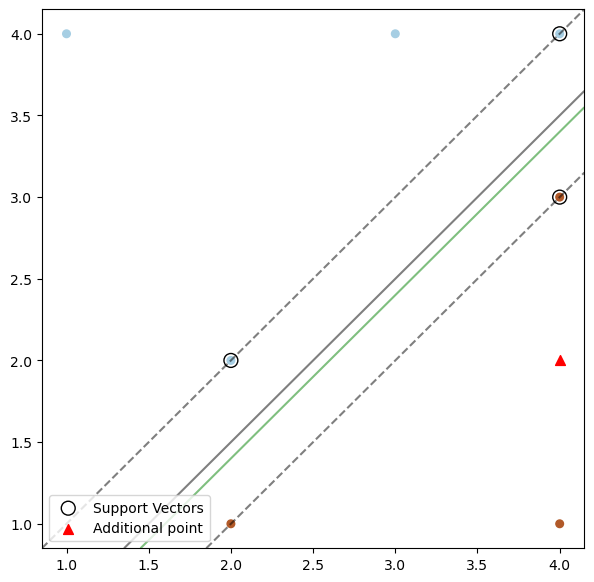

[-1.0004096] [[ 1.9998464 -1.9996928]]


In [55]:
# plot graph
fig, ax = plt.subplots(figsize=(7, 7))

# scatter plot of sample points
ax.scatter(sample_df.iloc[:, 0], sample_df.iloc[:, 1], 
           c=sample_df.iloc[:, -1], s=30, 
           cmap=plt.cm.Paired)

# create a grid
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

# hyperplane
lines1 = ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'], label="Decision Boundary")

# support vectors
ax.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k', label="Support Vectors")

# a hyperplane that is not optimal
lines2 = ax.contour(XX, YY, Z - 0.2, colors='g', levels=[0], alpha=0.5,
           linestyles=['-'])

# point make the data NOT linear-separable
ax.scatter([4.0], [2.0], color='r', marker='^', s=50, label="Additional point")

ax.legend()
plt.show()

print(model.intercept_, model.coef_)

# 5. ISLR 9.7.3

(b) Sketch the optimal separating hyperplane, and provide the equation for this hyperplane (of the form (9.1))

Ans: The solid black/grey line is the hyperplane


(c) Describe the classification rule for the maximal margin classifier. It should be something along the lines ofclassify to Red if b0+b1x1+b2x2 > 0, and classify to Blue otherwise. Provide the values for b0,b1,b2.

Ans: The parameters are as follows:
        b0=1, b1 = -1, b2 = 2
        b0+b1x1+b2x2 > 0 => red, otherwise blue

        

(d) On your sketch, indicate the margin for the maximal margin hyperplane.

Ans: The dashed line indicates the maximal margin.

    
(e) Indicate the support vectors for the maximal margin classifier.

Ans: The circled ones are the support vectors

    
(f) Argue that a slight movement of the seventh observation would not affect the maximal margin hyperplane

Ans: The seventh point is far away from the maximal margin hyperplane. If it is on the edge of the decision boundary, it will have effects, but it does not.

    
(g) Sketch a hyperplane that is not the optimal separating hyperplane, and provide the equation for this hyperplane.

Ans: The solid green line

(h) Draw an additional observation on the plot so that the two classes are no longer separable by a hyperplane 

Ans: The new point marked as a red triangle. This makes the points from an XOR pattern which is not linearly separable.